# Virtual Staining Tutorial: KI67 Synthesis with Deep Learning

This tutorial demonstrates how to build and train a deep learning model to virtually stain hematoxylin and eosin (H&E) images into corresponding immunohistochemistry (IHC) stained images using the **KI67** marker. 

We will walk through:
- Setting up the dataset and preprocessing
- Defining the generator and discriminator models
- Training with a combination of adversarial, pixel-wise, and perceptual losses
- Evaluating and visualizing the results

Dataset: *Acrobat 2023* (Virtual Staining Subset)

In [1]:
import numpy as np

import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset

import os
import glob
import torch
from torch.utils.data import Dataset
from torchvision import transforms
from PIL import Image

import albumentations as A
from albumentations.pytorch import ToTensorV2
from torch.optim.lr_scheduler import LambdaLR
import matplotlib.pyplot as plt

from torchmetrics.image.fid import FrechetInceptionDistance
from torchmetrics.image import PeakSignalNoiseRatio, StructuralSimilarityIndexMeasure

### Dataset Setup

This section defines the dataset used for virtual staining. We load paired H&E and KI67-stained whole slide images (WSIs) from the ACROBAT 2023 dataset that have been co-registered using VALIS and tiled into 256 x 256 patches at 40X magnification.

During training images are transformed using augmentations (e.g., flipping, rotating, normalization) to increase robustness and generalization. These tiles are loaded into a PyTorch Dataset that returns paired source and target images for training.

In [2]:
root_dir = "/ix1/qgu/ngl18/GLBIO2025_VirtualStaining"
train_source_files = sorted(list(glob.iglob(f"{root_dir}/data/train/he/**.npy")))
train_target_files = sorted(list(glob.iglob(f"{root_dir}/data/train/ki67/**.npy")))
val_source_files = sorted(list(glob.iglob(f"{root_dir}/data/valid/he/**.npy")))
val_target_files = sorted(list(glob.iglob(f"{root_dir}/data/valid/ki67/**.npy")))

In [3]:
from data import VirtualStainingDataset

train_transform = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.RandomRotate90(p=0.5),
    A.Affine(scale=(0.98, 1.02), translate_percent=0.05, rotate=(-5, 5), p=0.7),
    A.ElasticTransform(alpha=1, sigma=50, alpha_affine=5, p=0.2),
    A.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.05, p=0.7),
    A.RandomGamma(p=0.3),
    A.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5)),
    ToTensorV2()
], additional_targets={'target': 'image'}) 

val_test_transform = A.Compose([
    A.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5)),
    ToTensorV2()
], additional_targets={'target': 'image'}) 

train_virtual_staining_dataset = VirtualStainingDataset(train_source_files, train_target_files, 
                                                        transform=train_transform)
train_virtual_staining_dataloader = DataLoader(train_virtual_staining_dataset, batch_size=64, shuffle=True)

val_virtual_staining_dataset = VirtualStainingDataset(val_source_files, val_target_files, 
                                                        transform=val_test_transform)
val_virtual_staining_dataloader = DataLoader(val_virtual_staining_dataset, batch_size=64)

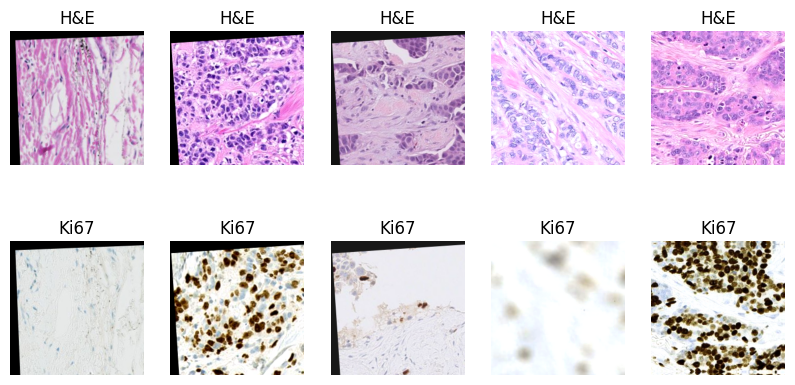

In [4]:
# View Examples
real, target = next(iter(train_virtual_staining_dataloader))[:5] # Replace with validation to avoid transforms
real = ((real + 1) / 2)
target = ((target + 1) / 2)

fig, ax = plt.subplots(nrows=2, ncols=5, figsize=(10, 5))

for i in range(5):
    ax[0, i].imshow(real[i].permute(1, 2, 0))
    ax[0, i].set_title("H&E")
    ax[0, i].axis('off')

    ax[1, i].imshow(target[i].permute(1, 2, 0))
    ax[1, i].set_title("Ki67")
    ax[1, i].axis('off')

### Model Setup
We use the **Pix2Pix** model, a conditional Generative Adversarial Network (cGAN) introduced by Isola et al. (2017) for image-to-image translation tasks. Pix2Pix consists of two main components:

- **Generator (G)**: Learns to map input H&E images to the corresponding KI67-stained images. It typically uses a U-Net architecture to preserve spatial features.
- **Discriminator (D)**: A PatchGAN discriminator evaluates the realism of local image patches, helping the generator produce realistic, high-frequency details.

In [5]:
from models import Generator, PatchDiscriminator

# Setup for device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
G = Generator(3).to(device)
D = PatchDiscriminator(3).to(device)

### Loss Function Setup

The generator is trained using a combination of:
- **Adversarial loss** (from the discriminator)
- **Pixel-wise loss** (L1 or MSE)
- **Perceptual loss** (encourages semantic similarity)
- **Structural Similarity Index Measure (SSIM)** loss (to emphasize image structure)

This combination helps the network generate visually convincing and anatomically accurate virtual stains.

In [6]:
from perceptual import VGGPerceptualLoss
from pytorch_msssim import ssim
import torch.nn.functional as F

# Model Training Parameters

# Loss function
adversarial_loss = nn.MSELoss()  # Adversarial loss (mean squared error)
pixelwise_loss = nn.L1Loss()  # Pixel-wise loss (L1 loss)
percep_loss_fn = VGGPerceptualLoss().to(device)
ssim = StructuralSimilarityIndexMeasure(data_range=2.0).to(device)

/ix1/qgu/ngl18/envs/vscc/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/ix1/qgu/ngl18/envs/vscc/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


### Loss Warmup and Scheduling Strategy

To stabilize training and balance the influence of different objectives, we implement a dynamic scheduling strategy for loss components. This approach gradually adjusts the contribution of each loss during training:

- **SSIM Loss Warmup**: We gradually increase the weight of SSIM loss from a small value to its full value over the course of training. This allows the model to learn coarse structural mappings before being penalized for fine structural differences.

- **Perceptual Loss Warmup**: We warm up the perceptual loss (based on VGG features) so that it becomes more prominent as the model gains capacity to reproduce semantically meaningful structures:

- **L1 Loss Decay**: To prevent over-reliance on pixel-wise accuracy and encourage perceptual realism, we gradually decay the weight of the L1 loss:

This ensures that early training focuses on alignment and pixel fidelity, while later stages prioritize perceptual quality and realism. Together, these schedules help balance low-level fidelity and high-level realism during virtual stain generation.

In [7]:
def get_lambda_ssim(curr_step, start=10, end=15, total_steps=50000):
    progress = min(curr_step / total_steps, 1.0)
    return start + progress * (end - start)

def get_lambda_percep(curr_step, start=0, end=0.5, total_steps=50000):
    progress = min(curr_step / total_steps, 1.0)
    return start + progress * (end - start)

def decay_lambda_l1(curr_step, start=10, end=2, total_steps=50000):
    progress = min(curr_step / total_steps, 1.0)
    return start - progress * (start - end)


### Training Parameter Setup

Here we define the training parameters including learning rates, number of training steps, and the warmup of the loss lambda values.

We also include linear decay schedules for the learning rate and optimizer learning rates. These settings control how quickly the model learns and how the importance of each loss component evolves during training.

In [8]:
# Learning Rates
lr_G = 0.0002 
lr_D = 0.0001

total_steps = 75000
lambda_stop = int(0.3 * total_steps)
start_decay = 35000

# === Training Params ===
log_interval = 1000
curr_step = 0

In [9]:
# === LR Scheduler: Linear decay after 25k steps to 50k ===
def linear_decay_lambda(step, start=start_decay, end=total_steps):
    if step < start:
        return 1.0
    else:
        return max(0.0, 1.0 - (step - start) / (end - start))

In [10]:
# Optimizers
optimizer_G = optim.Adam(G.parameters(), lr=lr_G, betas=(0.5, 0.999))
optimizer_D = optim.Adam(D.parameters(), lr=lr_D, betas=(0.5, 0.999))
scheduler_G = LambdaLR(optimizer_G, lr_lambda=linear_decay_lambda)

### Model Training

This is the main training loop where the generator and discriminator are updated iteratively.

Each training step includes:
- Forward passes through both networks
- Computation of adversarial, pixel, perceptual, and SSIM losses
- Warmup and decay of loss weights
- Backpropagation and optimizer updates

We periodically save checkpoints based on the validation SSIM and visualize model outputs to monitor training progress.

In [ ]:
from itertools import cycle

cyclic_loader = cycle(train_virtual_staining_dataloader)
best_ssim = 0

for real_images, target_images in cyclic_loader:
    G.train()
    
    if curr_step >= total_steps:
        break

    # === Move to device ===
    real_images = real_images.to(device)
    target_images = target_images.to(device)

    # === Discriminator ===
    optimizer_D.zero_grad()
    fake_images = G(real_images)

    real_preds = D(target_images)
    fake_preds = D(fake_images.detach())
    real_loss = adversarial_loss(real_preds, torch.ones_like(real_preds))
    fake_loss = adversarial_loss(fake_preds, torch.zeros_like(fake_preds))
    d_loss = (real_loss + fake_loss) / 2
    d_loss.backward()
    optimizer_D.step()

    # === Generator ===
    optimizer_G.zero_grad()
    fake_preds = D(fake_images)
    g_adv = adversarial_loss(fake_preds, torch.ones_like(fake_preds))
    g_l1 = pixelwise_loss(fake_images, target_images)
    g_ssim = 1 - ssim(fake_images, target_images)
    g_percep = percep_loss_fn(fake_images, target_images)
    g_loss = g_adv + decay_lambda_l1(curr_step, total_steps=lambda_stop) * g_l1 + get_lambda_ssim(curr_step, total_steps=lambda_stop) * g_ssim + get_lambda_percep(curr_step, total_steps=lambda_stop) * g_percep
    g_loss.backward()
    optimizer_G.step()
    scheduler_G.step()

    # === Logging & Saving ===
    if curr_step % log_interval == 0 or (curr_step + 1 >= total_steps):
        lr = scheduler_G.get_last_lr()[0]
        print(f"[Step {curr_step}] D Loss: {d_loss.item():.4f}, G Loss: {g_loss.item():.4f}, LR: {lr:.6f}")

        # === Visualization ===
        G.eval()
        val_ssim = 0.0
        with torch.no_grad():
            for real_images, target_images in val_virtual_staining_dataloader:
                out = G(real_images.to(device))
                val_ssim += ssim(out, target_images.to(device))

            val_ssim /= len(val_virtual_staining_dataloader)
            print(f"[Step {curr_step}] Valid SSIM: {val_ssim.item():.4f}")

            real_images, target_images = next(iter(val_virtual_staining_dataloader))
            
            he_sample = real_images[:4]
            ihc_sample = target_images[:4]
            ihc_pred = G(he_sample.to(device))
            def to_img(x): return (x * 0.5 + 0.5).clamp(0, 1)

            fig, axs = plt.subplots(3, 4, figsize=(12, 9))
            for j in range(4):
                axs[0, j].imshow(to_img(he_sample[j].permute(1, 2, 0)).cpu())
                axs[0, j].set_title("H&E")
                axs[1, j].imshow(to_img(ihc_sample[j].permute(1, 2, 0)).cpu())
                axs[1, j].set_title(f"Real IHC")
                axs[2, j].imshow(to_img(ihc_pred[j].permute(1, 2, 0)).cpu())
                axs[2, j].set_title(f"Virtual IHC")
                for row in axs: row[j].axis('off')
            plt.tight_layout()
            plt.savefig(f"/ix1/qgu/ngl18/GLBIO2025_VirtualStaining/samples/step_{curr_step}.png")
            plt.close()

        if val_ssim.item() >= best_ssim:
            torch.save({
            "step": curr_step,
            "val_ssim": val_ssim.item(),
            "G": G.state_dict(),
            "D": D.state_dict(),
            "optimizer_G": optimizer_G.state_dict(),
            "optimizer_D": optimizer_D.state_dict(),
            "scheduler_G": scheduler_G.state_dict(),
        }, f"/ix1/qgu/ngl18/GLBIO2025_VirtualStaining/ckpts/best.pth")
    
    # === Save Checkpoint ===
    torch.save({
        "step": curr_step,
        "G": G.state_dict(),
        "D": D.state_dict(),
        "optimizer_G": optimizer_G.state_dict(),
        "optimizer_D": optimizer_D.state_dict(),
        "scheduler_G": scheduler_G.state_dict(),
    }, f"/ix1/qgu/ngl18/GLBIO2025_VirtualStaining/ckpts/last.pth")

    curr_step += 1


[Step 0] D Loss: 0.7360, G Loss: 14.2802, LR: 0.000200
[Step 0] Valid SSIM: 0.0629


### Evaluation

To assess the quality of the virtually stained images, we use several complementary metrics:

- **Structural Similarity Index Measure (SSIM)**: Quantifies perceptual similarity in terms of luminance, contrast, and structural information. Values range from 0 to 1, with 1 indicating perfect similarity.
- **Peak Signal-to-Noise Ratio (PSNR)**: Evaluates the ratio between the maximum possible signal and the noise in the generated image. Higher PSNR indicates better image quality.
- **Fréchet Inception Distance (FID)**: Compares the distribution of real and generated images in a deep feature space (typically using InceptionV3). Lower FID scores indicate greater similarity between real and synthetic image distributions.
- 
These metrics together provide insight into both low-level pixel accuracy and high-level perceptual quality of the virtual stains.

In [ ]:
def evaluate_pix2pix(generator, val_dataloader, device="cuda"):
    # Define metrics
    fid = FrechetInceptionDistance(feature=2048, normalize=True)
    psnr = PeakSignalNoiseRatio(data_range=1.0)  # Data range should be 1.0 for normalized images
    ssim = StructuralSimilarityIndexMeasure(data_range=1.0)

    # Move to device
    fid = fid.to(device)
    psnr = psnr.to(device)
    ssim = ssim.to(device)
    
    # Ensure generator is in eval mode
    generator.eval()
    
    with torch.no_grad():
        for source, target in tqdm(val_dataloader):  # A = Input image, B = Ground truth
            source, target = source.to(device), target.to(device)

            # Generate fake images
            fake_target = generator(source).to(device)

            # Convert from [-1, 1] to [0, 1] for Inception (FID expects float in [0,255])
            target = ((target + 1) / 2).clamp(0, 1)
            fake_target = ((fake_target + 1) / 2).clamp(0, 1) 

            # Update FID metric
            fid.update(target.float(), real=True)   
            fid.update(fake_target.float(), real=False)  

            # Update SSIM and PSNR metrics
            ssim.update(fake_target, target)  # Fixed variable names
            psnr.update(fake_target, target)  

    # Compute final metrics
    fid_score = fid.compute()
    ssim_score = ssim.compute()
    psnr_score = psnr.compute()
    
    print(f"FID Score: {fid_score.item()}")
    print(f"SSIM Score: {ssim_score.item()}")
    print(f"PSNR Score: {psnr_score.item()}")

    return fid_score, ssim_score, psnr_score  # Return values for logging

In [ ]:
# Setup Testing
test_source_files = sorted(list(glob.iglob(f"{root_dir}/data/test/he/**.npy")))
test_target_files = sorted(list(glob.iglob(f"{root_dir}/data/test/ki67/**.npy")))
test_virtual_staining_dataset = VirtualStainingDataset(test_source_files, test_target_files, 
                                                       transform=val_test_transform)
test_virtual_staining_dataloader = DataLoader(test_virtual_staining_dataset, batch_size=64)


In [ ]:
# Load Checkpoint
ckpt = torch.load(f"/ix1/qgu/ngl18/GLBIO2025_VirtualStaining/ckpts/best.pth")
G = G.load_state_dict(ckpt["G"]).to(device)

In [ ]:
evaluate_pix2_pix(G, test_virtual_staining_dataloader, device=device)